# Titanic Survival Prediction

The sinking of the RMS Titanic on her maiden voyage has become one of the most well recognized shipwrecks in history. On April 15, 1912, 1502 of the 2224 passengers and crew members on board died. While the large loss of life may be attributed in part to the inadequate number of lifeboats, factors such as gender, age, and ticket class had a significant impact on who ultimately survived.

In this project, I will be using binary classification and machine learning concepts to predict which passengers survived the disaster.

The data for this project was taken from the Kaggle competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview/evaluation).

## Importing Libraries

In [337]:
# Linear algebra
import numpy as np

# Data processing
import pandas as pd

# Data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

## Loading the Data

In [338]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

## Data Exploration

In [339]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note that there are 891 entries, 11 features, and also the target vairable (whether the passenger survived). 5 of the features are integers, 2 are floats, and 5 are objects.

Below I have listed all the features and a short description of each.

In [340]:
%%html
<style>
table {float:left}
</style>

| Variable    | Definition                                              |
|-------------|---------------------------------------------------------|
| PassengerId | Unique ID for each passenger                            |
| Survived    | Whether the passenger survived or not (0 = No, 1 = Yes) |
| Pclass      | Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)                |
| Name        | Passenger name                                          |
| Sex         | Sex                                                     |
| Age         | Age in years                                            |
| SibSp       | Number of siblings / spouses aboard the Titanic         |
| Parch       | Number of parents / children aboard the Titanic         |
| Ticket      | Ticket number                                           |
| Fare        | Passenger fare                                          |
| Cabin       | Cabin number                                            |
| Embarked    | Port of embarkation                                     |

In [341]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From this we can see that the age column has missing values, as its count is not 891. We can also see that the age minimum is 0.4; ages were selected to be fractional when under 1.

In [342]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


From this we can see that we will need to convert some of the features to numeric features so that they can be processed. Some features also have missing values (NaN = not a number). We will look more closely at what data is missing.

In [343]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent1 = train_df.isnull().sum() / train_df.isnull().count() * 100
percent2 = (round(percent1, 1)).sort_values(ascending=False)
missing = pd.concat([total, percent2], axis=1, keys=['Total', '%'])
missing.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


While the "embarked" category only has 2 missing features and may be easy to work around, the "age" and "cabin" data have more significant amounts of missing values. The missing data for the cabin numbers is of a proportion great enough that we may simply choose to eliminate that variable from our dataset.

Looking at the 11 features, from a glance it appears that all may have played a role in passenger survival except for the passenger ID, name, and ticket number.

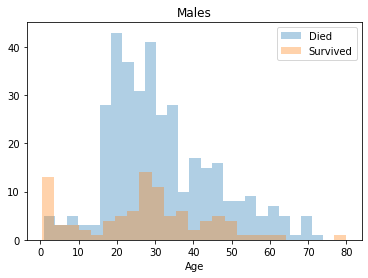

In [344]:
male_df = train_df[['Survived', 'Sex', 'Age']]

male_died = male_df.loc[(male_df.Sex == 'male') & (male_df.Survived == 0)]
male_survived = male_df.loc[(male_df.Sex == 'male') & (male_df.Survived == 1)]

male_surv_ages = male_survived['Age'].dropna()
male_died_ages = male_died['Age'].dropna()

plt.hist(x=male_died_ages, alpha=0.35, bins=25, label='Died')
plt.hist(x=male_surv_ages, alpha=0.35, bins=25, label='Survived')
plt.legend()
plt.xlabel('Age')
plt.title('Males')
plt.show()

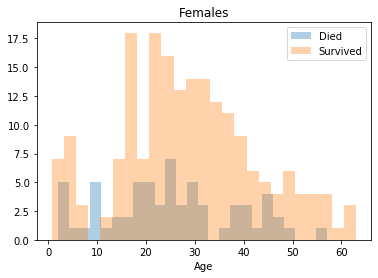

In [345]:
female_df = train_df[['Survived', 'Sex', 'Age']]

female_died = female_df.loc[(male_df.Sex == 'female') & (male_df.Survived == 0)]
female_survived = female_df.loc[(male_df.Sex == 'female') & (male_df.Survived == 1)]

female_surv_ages = female_survived['Age'].dropna()
female_died_ages = female_died['Age'].dropna()

plt.hist(x=female_died_ages, alpha=0.35, bins=25, label='Died')
plt.hist(x=female_surv_ages, alpha=0.35, bins=25, label='Survived')
plt.legend()
plt.xlabel('Age')
plt.title('Females')
plt.show()

From the graphs, it is obvious that women fared much better for survival than men. Infants of both genders also had higher survival. Interestingly, males aged 5 to 18 had lower survival rates, while this is less true for females. Men between 20 and 40 and women between 15 and 30 had increased survival rates.

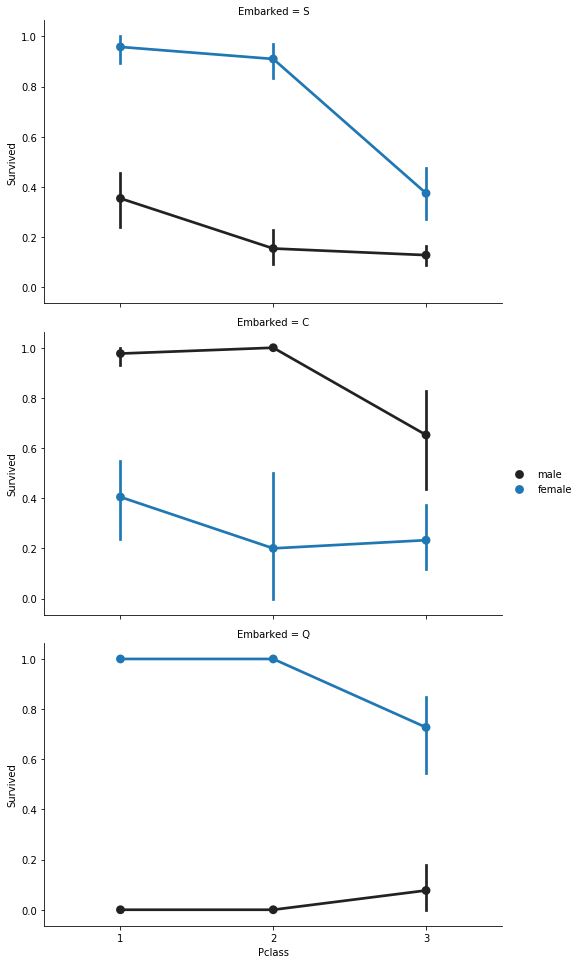

In [346]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

The port of embarkation also seems to be correlated with survival. Women on Port Q and Port S had a higher chance of survival. Men on Port C had a higher chance of survival, but had lower chances of survival if they embarked on Ports Q or S.

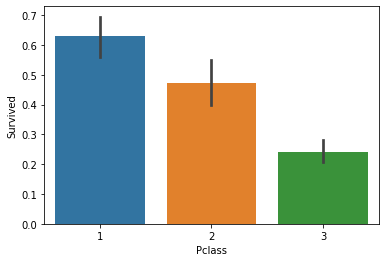

In [347]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

This bar graph shows that the passenger's class had a strong impact on the passenger's chance of survival.

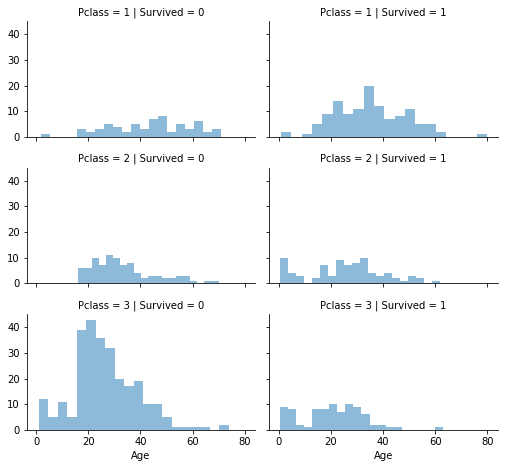

In [348]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The variables for siblings/spouses and parents/children aboard would be more easily viewed together as a variable of total siblings on board, so we will determine if someone on board is alone or not.

In [349]:
data = [train_df, test_df]

for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']   
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

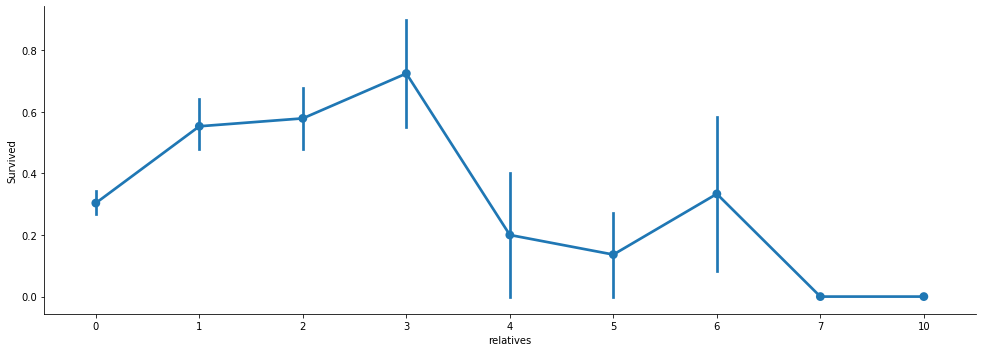

In [350]:
axes = sns.factorplot('relatives','Survived', data=train_df, aspect =2.75)

We can see that having more than three relatives on board correlated with lower survival.

## Data Cleaning and Processing

We will drop Passenger ID from the data, as it is an arbitrary number that had no impact on mortality outcome. We are not going to drop the feature from the test set, as it is required for submission.

In [351]:
train_df = train_df.drop('PassengerId', axis=1)

### Missing Data Values



We will also drop the cabin number variable, as 77.1% of the data values are missing (687/891).

In [352]:
train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

Next, we will tackle the missing age values. As there are 177, this is not too big of an issue. We will assign random ages based on the mean and standard deviation of the other age values.

In [353]:
data = [train_df, test_df]

for dataset in data:
    mean = np.mean(train_df['Age'])
    std_dev = np.std(train_df['Age'])
    null_values = dataset['Age'].isnull().sum()
    random_ages = np.random.randint(mean - std_dev, mean + std_dev, size=null_values)
    sliced_ages = dataset['Age'].copy()
    sliced_ages[np.isnan(sliced_ages)] = random_ages
    dataset['Age'] = sliced_ages
    dataset['Age'] = train_df['Age'].astype(int)

There are only 2 missing embarked values. An easy solution will just be to fill the non-assigned values with the most common port of embarkation.

In [354]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [355]:
most_common = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(most_common)

### Converting Features

In [356]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 83.7+ KB


Note that we have 4 categorical variables: name, sex, ticket, and embarked. We will deal with those and also change the 'Fare' feature to an integer.

Convert fare to integer:

In [357]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

Convert sex to numeric:

In [358]:
data = [train_df, test_df]
genders = {'male': 0, 'female': 1}

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

Convert embarked to numeric:

In [359]:
data = [train_df, test_df]
ports = {'S': 0, 'C': 1, 'Q': 2}

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

We will drop the name feature:

In [361]:
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)

We will drop the ticket feature:

In [363]:
train_df = train_df.drop('Ticket', axis=1)
test_df = test_df.drop('Ticket', axis=1)

# Machine Learning Models

In [367]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

### Random Forest

In [368]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

### Logistic Regression

In [370]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### K  Nearest Neighbour

In [379]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train,Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

## Determining Which Model is Best

In [380]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'KNN'],
    'Score': [acc_random_forest, acc_log, acc_knn]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
96.75,Random Forest
82.72,KNN
80.47,Logistic Regression
